In [303]:
! pip install -q -r requirements.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Data Collection from WikiPedia!

In [304]:
import wikipedia
text = wikipedia.page("OpenAI")

In [305]:
with open("example.txt",'w') as f:
    f.write(text.content)
    f.close()

# Data Preprocessing

In [306]:
import pandas as pd

texts =[] # list to store the text

# open and read the file
with open("example.txt",'r') as f:
    text = f.read()

### Tokenizer

In [307]:
import tiktoken
tokenizer = tiktoken.get_encoding('cl100k_base') # Load the cl100k_base tokenizer (ada-002 model)
tokens = tokenizer.encode(text)
len(tokens)

5877

### Spliting Text File

In [308]:

sentences = text.split('.') # split sentences
n_tokens = [len(tokenizer.encode(" "+ sentence)) for sentence in sentences]
len(n_tokens)

196

In [309]:
chunks = []
max_tokens = 100
tokens_so_far = 0
chunk = []

#splitting sentence based on the maximum tokens
for sentence, token in zip(sentences,n_tokens): #
    if token + tokens_so_far > max_tokens: 
        chunks.append(". ".join(chunk) + ".")
        chunk = []
        tokens_so_far = 0
    
    if token>max_tokens:
        continue
    
    chunk.append(sentence)
    tokens_so_far += token + 1
len(chunks)

72

<Axes: >

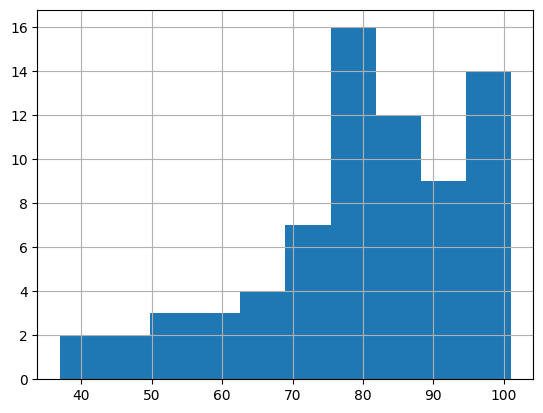

In [311]:
# creating data frame with splitted sentences and corresonding tokens
df = pd.DataFrame(chunks, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

# Create Embeddings

### Intialise embedding model

In [312]:
from sentence_transformers import SentenceTransformer
model_name = 'msmarco-distilbert-base-tas-b'
model = SentenceTransformer(model_name)

### create embeddings

In [313]:
sentences = df['text'].tolist()
embeddings = model.encode(sentences)

In [314]:
# creating data frame with splitted sentences and corresonding tokens
embed_df = pd.DataFrame(sentences, columns = ['text'])
embed_df['embeddings'] = df.text.apply(lambda x: model.encode(x))
embed_df
    

,text,embeddings
0,OpenAI is an American artificial intelligence ...,"[-0.0933873, -0.07241815, -0.02766451, -0.0787..."
1,\nOpenAI was founded in 2015 by Ilya Sutskever...,"[0.14573932, 0.25977483, 0.4820659, 0.07460609..."
2,Microsoft provided OpenAI LP with a $1 billio...,"[-0.13870591, 0.3027339, 0.2933645, 0.2538226,..."
3,"According an investigation led by TechCrunch,...","[-0.011180686, 0.22425674, -0.12160659, 0.2025..."
4,"According to Wired, Brockman met with Yoshua B...","[0.1161643, 0.19548754, -0.052780043, 0.302446..."
...,...,...
67,Microscope was created to analyze the feature...,"[0.059010543, -0.38252774, 0.40526044, 0.04978..."
68,"Also revealed in 2021, CLIP does the opposite:...","[-0.22941588, -0.32944718, 0.21696362, -0.0690..."
69,"It can create images of realistic objects (""a...","[0.17072138, -0.027752336, 0.17155954, -0.2389..."
70,"In December 2022, OpenAI published on GitHub ...","[-0.7152545, -0.13176711, 0.28895915, 0.001053..."


# Similarity Search

### Cosine Similarity

In [315]:
import torch
import numpy as np
from sentence_transformers import util
question = """who founded openai"""
embed_q = model.encode(question)

In [316]:
top_k = min(5, len(sentences))
top_k


5

In [317]:
cosine_scores = util.cos_sim(embed_q,embeddings)[0]
top_results = torch.topk(cosine_scores, k=5)
top_results


torch.return_types.topk(
values=tensor([0.8864, 0.8769, 0.8531, 0.8458, 0.8336]),
indices=tensor([ 1,  0,  6, 15, 19]))

# Retreiving Context and Feeding to LLM

In [328]:
context =""
for i in top_results.indices:
    # print(embed_df['text'][i.item()])
    context += embed_df['text'][i.item()] + " "

### HF QA Pipeline

In [337]:
from transformers import pipeline
qa_model = pipeline("question-answering", model='deepset/roberta-base-squad2')
qa_model(question="what is connection between Elon Musk and OpenAI?", context = context)

{'score': 0.03824403136968613,
 'start': 249,
 'end': 262,
 'answer': 'board members'}